# Unsupervised Machine Learning Clustering

## Data Preprocessing

### Importing Libraries

In [33]:
import pandas as pd
import wbgapi as wb
import numpy as np
from math import pi
import matplotlib.pyplot as plt

from functools import reduce

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import adjusted_rand_score

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import cdist

import warnings
warnings.filterwarnings('ignore')

### Soil pH

In [2]:
# Reading and filtering the data
ph_data = pd.read_csv('ph_data.tsv', sep='\t')

# Filtering for topsoil and valid pH
topsoil_ph = ph_data[(ph_data['upper_depth'] >= 0) & 
                    (ph_data['lower_depth'] <= 30) &
                    (ph_data['value_avg'] > 3.0) & 
                    (ph_data['value_avg'] < 11.0)]

# Extracting year
topsoil_ph['year'] = pd.to_numeric(topsoil_ph['date'].str[:4], errors='coerce')

# Calculating country average
def calculate_country_stats(group):
    total_samples = len(group)
    recent = group[group['year'] >= 2015]
    recent_samples = len(recent)
    
    if recent_samples >= 5:
        ph_mean = recent['value_avg'].mean()
    else:
        ph_mean = group['value_avg'].mean()
    
    return pd.Series({'ph': round(ph_mean, 2), 'n_samples': total_samples})

# Grouping by country and filtering
country_ph = topsoil_ph.groupby('country_name').apply(calculate_country_stats, include_groups=False)
country_ph = country_ph[country_ph['n_samples'] >= 5].reset_index()

# Creating simple version for clustering
final_ph = country_ph[['country_name', 'ph']].copy()
final_ph = final_ph.rename(columns={'country_name': 'country'})

print(f"Total countries with sufficient data: {len(final_ph)}")

# Listing excluded countries
all_countries = set(ph_data['country_name'].unique())
included_countries = set(final_ph['country'].unique())
excluded_countries = all_countries - included_countries

print(f"\nCountries excluded: {len(excluded_countries)}")
if len(excluded_countries) > 0:
    print(list(excluded_countries))

Total countries with sufficient data: 144

Countries excluded: 16
['Luxembourg', 'Kyrgyzstan', 'Dominican Republic', 'Slovenia', 'Iran (Islamic Republic of)', 'Vanuatu', 'Arunachal Pradesh', 'Palau', 'Tajikistan', 'Solomon Islands', 'Trinidad and Tobago', 'Bahrain', 'Serbia', 'New Caledonia', 'Netherlands Antilles', 'Paraguay']


### Soil Sand

In [3]:
# Reading and filtering the data
sand_data = pd.read_csv('sand_data.tsv', sep='\t')

# Filtering for topsoil and valid sand
topsoil_sand = sand_data[(sand_data['upper_depth'] >= 0) & 
                    (sand_data['lower_depth'] <= 30) &
                    (sand_data['value_avg'] >= 0.0) & 
                    (sand_data['value_avg'] <= 100.0)]

# Extracting year
topsoil_sand['year'] = pd.to_numeric(topsoil_sand['date'].str[:4], errors='coerce')

# Calculating country average
def calculate_country_stats(group):
    total_samples = len(group)
    recent = group[group['year'] >= 2015]
    recent_samples = len(recent)
    
    if recent_samples >= 5:
        sand_mean = recent['value_avg'].mean()
    else:
        sand_mean = group['value_avg'].mean()
    
    return pd.Series({'sand': round(sand_mean, 2), 'n_samples': total_samples})

# Grouping by country and filtering
country_sand = topsoil_sand.groupby('country_name').apply(calculate_country_stats, include_groups=False)
country_sand = country_sand[country_sand['n_samples'] >= 5].reset_index()

# Creating simple version for clustering
final_sand = country_sand[['country_name', 'sand']].copy()
final_sand = final_sand.rename(columns={'country_name': 'country'})

print(f"Total countries with sufficient data: {len(final_ph)}")

# Listing excluded countries
all_countries = set(sand_data['country_name'].unique())
included_countries = set(final_sand['country'].unique())
excluded_countries = all_countries - included_countries

print(f"\nCountries excluded: {len(excluded_countries)}")
if len(excluded_countries) > 0:
    print(list(excluded_countries))

Total countries with sufficient data: 144

Countries excluded: 17
['Kuwait', 'Barbados', 'Kyrgyzstan', 'Dominican Republic', 'Kazakhstan', 'Vanuatu', 'Arunachal Pradesh', 'Palau', 'Saudi Arabia', 'Tajikistan', 'Solomon Islands', 'Trinidad and Tobago', 'Greenland', 'Bahrain', 'New Caledonia', 'Croatia', 'Paraguay']


### Precipitation

In [4]:
# Getting average annual precipitation since 2015
final_precip = wb.data.DataFrame('AG.LND.PRCP.MM', economy='all', time=range(2015, 2024), mrnev=1, labels=True)

# Formatting the data
final_precip = final_precip.reset_index()
final_precip = final_precip[['Country', 'AG.LND.PRCP.MM']].copy()
final_precip.rename(columns={'AG.LND.PRCP.MM': 'precip_mm', 'Country': 'country'}, inplace=True)

# Previewing
final_precip.head()

,country,precip_mm
0,Afghanistan,327.0
1,Albania,1485.0
2,Algeria,89.0
3,Angola,1010.0
4,Antigua and Barbuda,1030.0


### % Employment in Agriculture

In [5]:
# Getting most recent employment values since 2015
final_agr_employment = wb.data.DataFrame('SL.AGR.EMPL.ZS', economy='all', time=range(2015, 2024), mrnev=1, labels=True)

# Formatting the data
final_agr_employment = final_agr_employment.reset_index()
final_agr_employment = final_agr_employment[['Country', 'SL.AGR.EMPL.ZS']].copy()
final_agr_employment.rename(columns={'SL.AGR.EMPL.ZS': 'agr_employment', 'Country': 'country'}, inplace=True)

# Previewing 
final_agr_employment.head()

,country,agr_employment
0,Africa Eastern and Southern,55.942418
1,Africa Western and Central,40.030929
2,Arab World,13.612111
3,Caribbean small states,8.393993
4,Central Europe and the Baltics,7.671682


### % Prevelance of Moderate or Severe Food Insecurity

In [6]:
# Fetching the most recent value since 2015
final_food_insecurity = wb.data.DataFrame('SN.ITK.MSFI.ZS', economy='all', time=range(2000, 2024), mrnev=1, labels=True)

# Formatting
final_food_insecurity = final_food_insecurity.reset_index()
final_food_insecurity = final_food_insecurity[['Country', 'SN.ITK.MSFI.ZS']].copy()
final_food_insecurity.rename(columns={'SN.ITK.MSFI.ZS': 'food_insecurity_pct', 'Country': 'country'}, inplace=True)

# Preview
final_food_insecurity.head()

,country,food_insecurity_pct
0,Afghanistan,80.9
1,Albania,32.2
2,Algeria,18.9
3,Angola,79.2
4,Antigua and Barbuda,33.0


### % Smallholder Farms

In [7]:
# Reading the data
holdings_data = pd.read_csv('holdings_data.csv')

# Getting most recent year for each country
latest_years = holdings_data.groupby('Area')['Census Year'].max().reset_index()
latest_years.columns = ['Area', 'Latest_Year']

# Merging to keep only latest year data
holdings_latest = holdings_data.merge(latest_years, on='Area')
holdings_latest = holdings_latest[holdings_latest['Census Year'] == holdings_latest['Latest_Year']]

# Defining smallholder categories
smallholder_categories = [
    'Holdings with land size 0-<1',
    'Holdings with land size 1-<2', 
    'Holdings with land size 2-<5']

# Calculating smallholder numbers for each country
smallholders = holdings_latest[holdings_latest['Item'].isin(smallholder_categories)].groupby('Area')['Value'].sum().reset_index()
smallholders.columns = ['Area', 'Smallholder_Count']

# Adding all size categories
all_size_categories = holdings_latest[holdings_latest['Item'].str.contains('Holdings with land size')]['Item'].unique()
total_holdings = holdings_latest[holdings_latest['Item'].isin(all_size_categories)].groupby('Area')['Value'].sum().reset_index()
total_holdings.columns = ['Area', 'Total_Holdings']

# Merging and calculating percentage
smallholdings = smallholders.merge(total_holdings, on='Area')
smallholdings['smallholder_pct'] = ((smallholdings['Smallholder_Count'] / smallholdings['Total_Holdings']) * 100).round(2)

# Merging census year info with smallholdings
year_info = holdings_latest[['Area', 'Census Year']].drop_duplicates()
smallholdings = smallholdings.merge(year_info, on='Area')

# Create the full results dataset with all information
result = smallholdings[['Area', 'smallholder_pct', 'Census Year', 'Smallholder_Count', 'Total_Holdings']].copy()
result = result.sort_values('Area')

# Creating a simple clustering version
final_smallholdings = result[['Area', 'smallholder_pct']].copy()
final_smallholdings.rename(columns={'Area': 'country'}, inplace=True)


# Previewing
final_smallholdings.head()

,country,smallholder_pct
0,Albania,90.70
1,Algeria,57.81
2,American Samoa,93.17
3,Antigua and Barbuda,97.91
4,Argentina,6.30


### Tropicality

In [8]:
# Reading latitude data
latitude = pd.read_csv('latitude.csv')

# Calculating absolute latitude
latitude['abs_latitude'] = latitude['Latitude'].abs()

# Classifying climate zone:
def classify_climate(lat):
    if lat <= 23.5:
        return 2  
    elif lat <= 35:
        return 1 
    else:
        return 0 

latitude['tropical_climate'] = latitude['abs_latitude'].apply(classify_climate)

# Creating a simple clustering dataset 
final_tropical = latitude[['name', 'tropical_climate']].copy()
final_tropical.rename(columns={'name': 'country'}, inplace=True)

# Previewing
final_tropical.head()

,country,tropical_climate
0,Australia,1
1,Brunei,2
2,Cambodia,2
3,China,1
4,Fiji,2


### Merging the Datasets

In [13]:
country_mapping = {
    'Occupied Palestinian Territory': 'Palestine',
    'Bahamas, The': 'Bahamas',
    'Bolivia (Plurinational State of)': 'Bolivia',
    'Brunei Darussalam': 'Brunei',
    'Congo, Dem. Rep.': 'Democratic Republic of the Congo',
    'Congo, Rep.': 'Congo',
    "CÃ´te d'Ivoire": "Côte d'Ivoire",
    "Cote d'Ivoire": "Côte d'Ivoire",
    'Egypt, Arab Rep.': 'Egypt',
    'Gambia, The': 'Gambia',
    'Hong Kong SAR, China': 'Hong Kong, China',
    'Iran, Islamic Rep.': 'Iran',
    'Iran (Islamic Republic of)': 'Iran',
    'Korea, Rep.': 'South Korea',
    'Republic of Korea': 'South Korea',
    'Kyrgyz Republic': 'Kyrgyzstan',
    'Micronesia (Federated States of)': 'Micronesia',
    'Micronesia, Fed. Sts.': 'Micronesia',
    'Slovak Republic': 'Slovakia',
    'Syrian Arab Republic': 'Syria',
    'Turkiye': 'Türkiye',
    'Turkey': 'Türkiye',
    'United Kingdom of Great Britain and Northern Ireland': 'United Kingdom',
    'United Republic of Tanzania': 'Tanzania',
    'United States of America': 'United States',
    'Venezuela (Bolivarian Republic of)': 'Venezuela',
    'Venezuela, RB': 'Venezuela',
    'Yemen, Rep.': 'Yemen',
    'Republic of Moldova': 'Moldova',
    'Russian Federation': 'Russia',
    'Czechia': 'Czech Republic',
    'Swaziland': 'Eswatini',
    'Netherlands (Kingdom of the)': 'Netherlands'}

# Function to standardise country names
def standardise_country_names(df, country_name):
    df = df.copy()
    df.loc[:, country_name] = df[country_name].replace(country_mapping)
    return df

In [14]:
# Standardising country names in each dataset
final_ph = standardise_country_names(final_ph, 'country')
final_sand = standardise_country_names(final_sand, 'country')
final_precip = standardise_country_names(final_precip, 'country')
final_agr_employment = standardise_country_names(final_agr_employment, 'country')
final_smallholdings = standardise_country_names(final_smallholdings, 'country')
final_food_insecurity = standardise_country_names(final_food_insecurity, 'country')
final_tropical = standardise_country_names(final_tropical, 'country')

In [15]:
# Listing dataframes
dfs = [final_ph, final_sand, final_precip, final_agr_employment, final_smallholdings, final_food_insecurity, final_tropical]

# Merging on the country column with outer join
merged_df = reduce(lambda left, right: left.merge(right, on='country', how='outer'), dfs)

In [16]:
# Removing countries with any missing values for clustering
clustering_data = merged_df.dropna().reset_index(drop=True)
print(f"\nFinal countries for clustering: {len(clustering_data)}")


Final countries for clustering: 97


## Clustering

### Preparing and Scaling the Data

In [17]:
# Selecting feature columns
feature_columns = [col for col in clustering_data.columns if col != 'country']

# Creating a scaler
scaler = MinMaxScaler()

# Fitting and transforming the features
X_scaled = scaler.fit_transform(clustering_data[feature_columns])

# Verifying scaling
print(f"Min values: {X_scaled.min(axis=0)}")
print(f"Max values: {X_scaled.max(axis=0)}")

Min values: [0. 0. 0. 0. 0. 0. 0.]
Max values: [1. 1. 1. 1. 1. 1. 1.]


### Splitting Data into Train/Validate/Test

In [18]:
# First split separating the test set
X_temp, X_test, idx_temp, idx_test = train_test_split(
    X_scaled, 
    np.arange(len(clustering_data)), 
    test_size=0.2, 
    random_state=42)

# Second split separating train and validation
X_train, X_val, idx_train, idx_val = train_test_split(
    X_temp, 
    idx_temp, 
    test_size=0.25,
    random_state=42)

print(f"Train set: {len(X_train)} countries")
print(f"Validation set: {len(X_val)} countries")
print(f"Test set: {len(X_test)} countries")

Train set: 57 countries
Validation set: 20 countries
Test set: 20 countries


### Finding Optimal K using Train and Validation

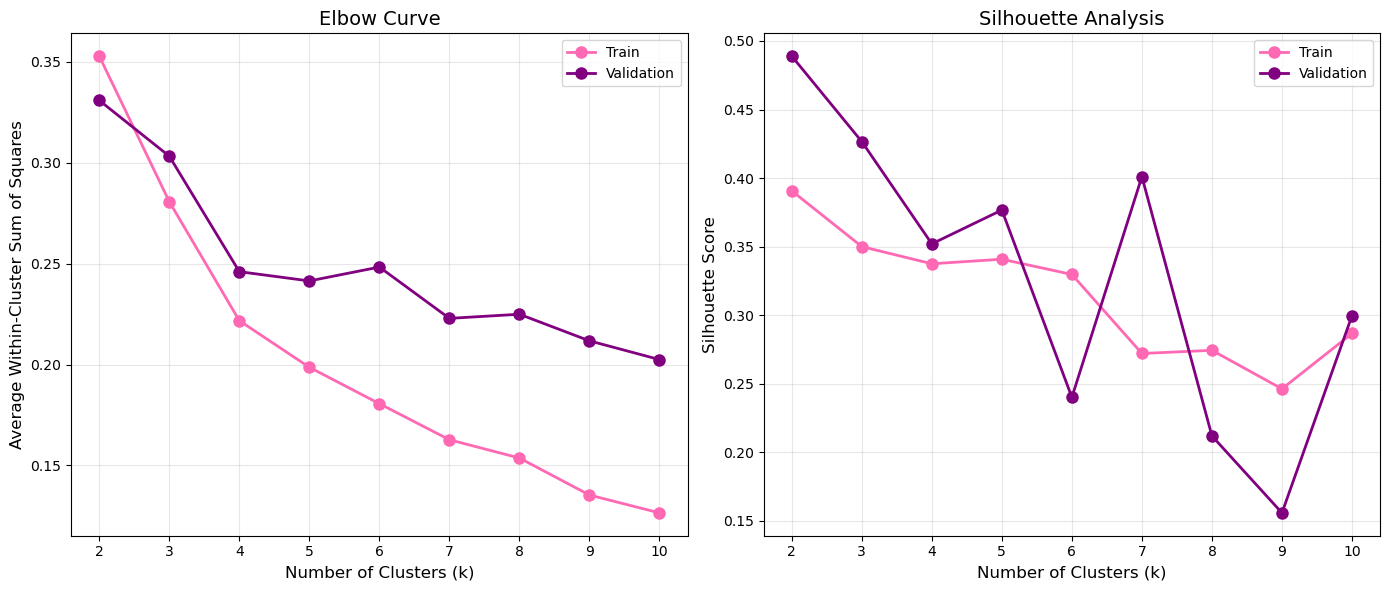

In [19]:
k_range = range(2, 11)
train_inertias = []
val_inertias = []
train_silhouettes = []
val_silhouettes = []

# Training k only on the train set
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_train)
    
    train_labels = kmeans.labels_
    
    # Assigning validation without re-training
    val_labels = kmeans.predict(X_val)
    
    # Calculating inertias for elbow curve
    train_inertias.append(kmeans.inertia_ / len(X_train))
    val_inertia = np.sum(np.min(kmeans.transform(X_val)**2, axis=1)) / len(X_val)
    val_inertias.append(val_inertia)
    
    # Calculating silhouette scores
    train_sil = silhouette_score(X_train, train_labels)
    val_sil = silhouette_score(X_val, val_labels)
    train_silhouettes.append(train_sil)
    val_silhouettes.append(val_sil)

# Creating visualisation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Elbow curve
ax1.plot(k_range, train_inertias, color='hotpink', marker='o', linestyle='-', label='Train', linewidth=2, markersize=8)
ax1.plot(k_range, val_inertias, color='purple', marker='o', linestyle='-', label='Validation', linewidth=2, markersize=8)
ax1.set_xlabel('Number of Clusters (k)', fontsize=12)
ax1.set_ylabel('Average Within-Cluster Sum of Squares', fontsize=12)
ax1.set_title('Elbow Curve', fontsize=14)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Silhouette scores
ax2.plot(k_range, train_silhouettes, color='hotpink', marker='o', linestyle='-', label='Train', linewidth=2, markersize=8)
ax2.plot(k_range, val_silhouettes, color='purple', marker='o', linestyle='-', label='Validation', linewidth=2, markersize=8)
ax2.set_xlabel('Number of Clusters (k)', fontsize=12)
ax2.set_ylabel('Silhouette Score', fontsize=12)
ax2.set_title('Silhouette Analysis', fontsize=14)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("cluster_validation.pdf", format="pdf")
plt.show()

### Test Data

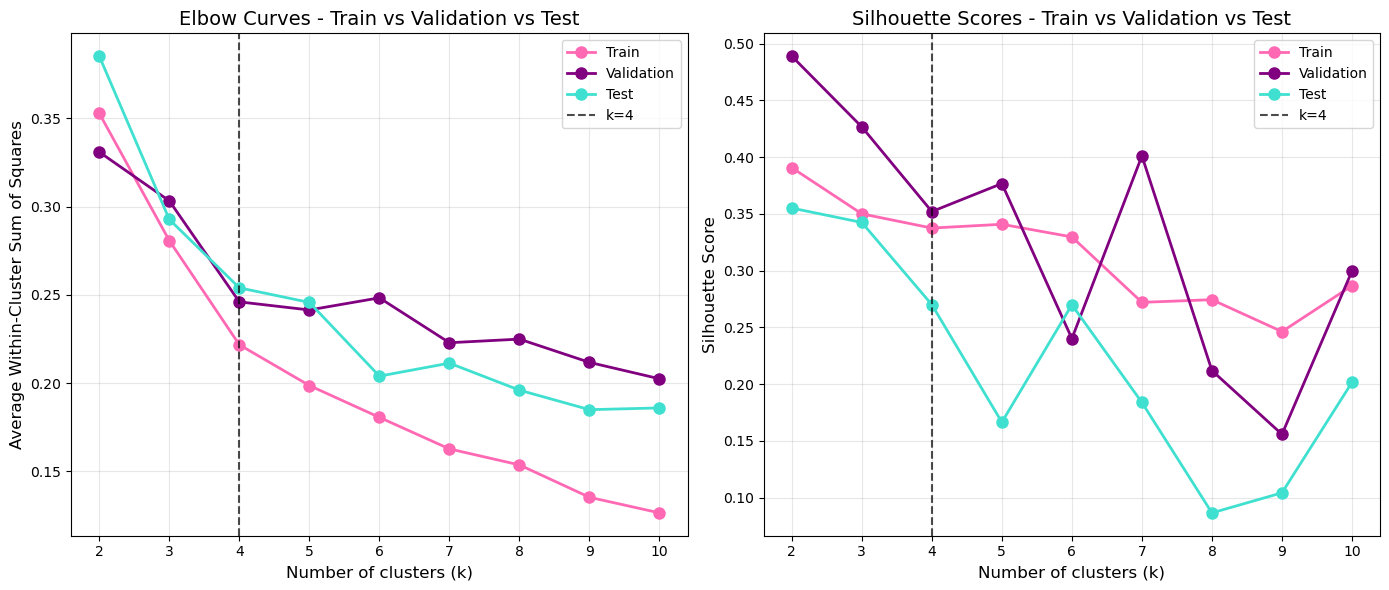


Performance at k=4:
Silhouette scores:
  Train: 0.337
  Validation: 0.352
  Test: 0.270
  Train-Test gap: 0.068

Inertia values:
  Train: 0.222
  Validation: 0.246
  Test: 0.254


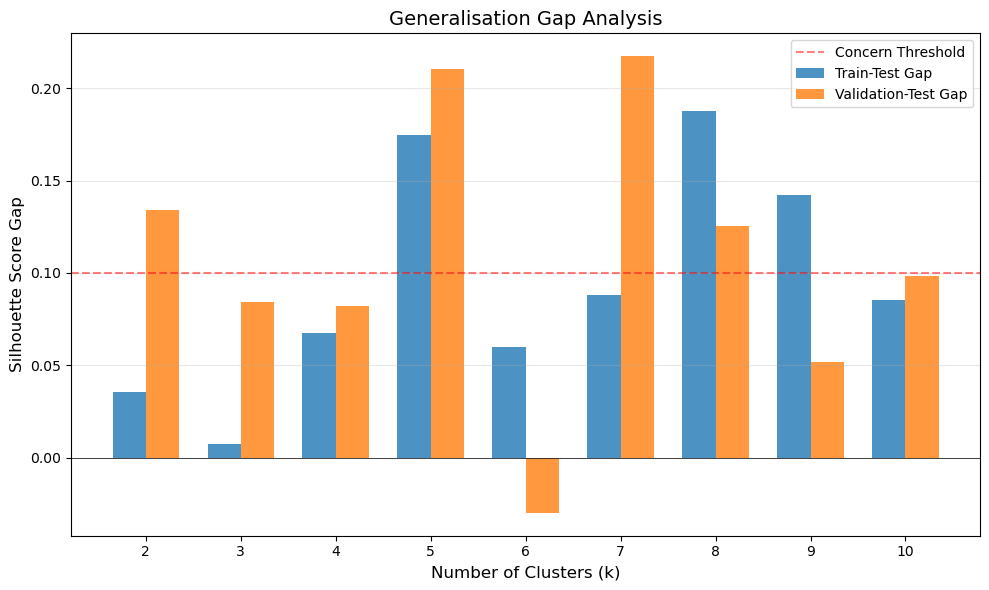

In [20]:
# Defining optimal k based on above graphs
optimal_k = 4

# Calculating metrics for all k values on test set for comparison
test_inertias = []
test_silhouettes = []

# Retraining models on train+val for each k
for k in k_range:

    X_train_val = np.vstack([X_train, X_val])
    
    kmeans_trainval = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_trainval.fit(X_train_val)
    
    test_labels = kmeans_trainval.predict(X_test)
    
    test_inertia = np.sum(np.min(kmeans_trainval.transform(X_test)**2, axis=1)) / len(X_test)
    test_silhouette = silhouette_score(X_test, test_labels)
    
    test_inertias.append(test_inertia)
    test_silhouettes.append(test_silhouette)

# Creating comparison visualisation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Elbow curve comparison
ax1.plot(k_range, train_inertias, color='hotpink', marker='o', linestyle='-', label='Train', linewidth=2, markersize=8)
ax1.plot(k_range, val_inertias, color='purple', marker='o', linestyle='-', label='Validation', linewidth=2, markersize=8)
ax1.plot(k_range, test_inertias, color='turquoise', marker='o', linestyle='-', label='Test', linewidth=2, markersize=8)

ax1.axvline(x=optimal_k, color='black', linestyle='--', alpha=0.7, label=f'k={optimal_k}')
ax1.set_xlabel('Number of clusters (k)', fontsize=12)
ax1.set_ylabel('Average Within-Cluster Sum of Squares', fontsize=12)
ax1.set_title('Elbow Curves - Train vs Validation vs Test', fontsize=14)
ax1.legend()
ax1.grid(True, alpha=0.3)

# Silhouette score comparison
ax2.plot(k_range, train_silhouettes, color='hotpink', marker='o', linestyle='-', label='Train', linewidth=2, markersize=8)
ax2.plot(k_range, val_silhouettes, color='purple', marker='o', linestyle='-', label='Validation', linewidth=2, markersize=8)
ax2.plot(k_range, test_silhouettes, color='turquoise', marker='o', linestyle='-', label='Test', linewidth=2, markersize=8)
ax2.axvline(x=optimal_k, color='black', linestyle='--', alpha=0.7, label=f'k={optimal_k}')
ax2.set_xlabel('Number of clusters (k)', fontsize=12)
ax2.set_ylabel('Silhouette Score', fontsize=12)
ax2.set_title('Silhouette Scores - Train vs Validation vs Test', fontsize=14)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("cluster_test.pdf", format="pdf")
plt.show()

# Analysing performance at optimal k
optimal_idx = list(k_range).index(optimal_k)
train_sil_optimal = train_silhouettes[optimal_idx]
val_sil_optimal = val_silhouettes[optimal_idx]
test_sil_optimal = test_silhouettes[optimal_idx]

train_inertia_optimal = train_inertias[optimal_idx]
val_inertia_optimal = val_inertias[optimal_idx]
test_inertia_optimal = test_inertias[optimal_idx]

print(f"\nPerformance at k={optimal_k}:")
print(f"Silhouette scores:")
print(f"  Train: {train_sil_optimal:.3f}")
print(f"  Validation: {val_sil_optimal:.3f}")
print(f"  Test: {test_sil_optimal:.3f}")
print(f"  Train-Test gap: {abs(train_sil_optimal - test_sil_optimal):.3f}")

print(f"\nInertia values:")
print(f"  Train: {train_inertia_optimal:.3f}")
print(f"  Validation: {val_inertia_optimal:.3f}")
print(f"  Test: {test_inertia_optimal:.3f}")

# Creating overfit analysis
plt.figure(figsize=(10, 6))
train_test_gaps = [train_silhouettes[i] - test_silhouettes[i] for i in range(len(k_range))]
val_test_gaps = [val_silhouettes[i] - test_silhouettes[i] for i in range(len(k_range))]

x = np.arange(len(k_range))
width = 0.35

plt.bar(x - width/2, train_test_gaps, width, label='Train-Test Gap', alpha=0.8)
plt.bar(x + width/2, val_test_gaps, width, label='Validation-Test Gap', alpha=0.8)
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
plt.axhline(y=0.1, color='red', linestyle='--', alpha=0.5, label='Concern Threshold')

plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Silhouette Score Gap', fontsize=12)
plt.title('Generalisation Gap Analysis', fontsize=14)
plt.xticks(x, k_range)
plt.legend()
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

### Performing Clustering on All Countries

<Figure size 1000x600 with 0 Axes>

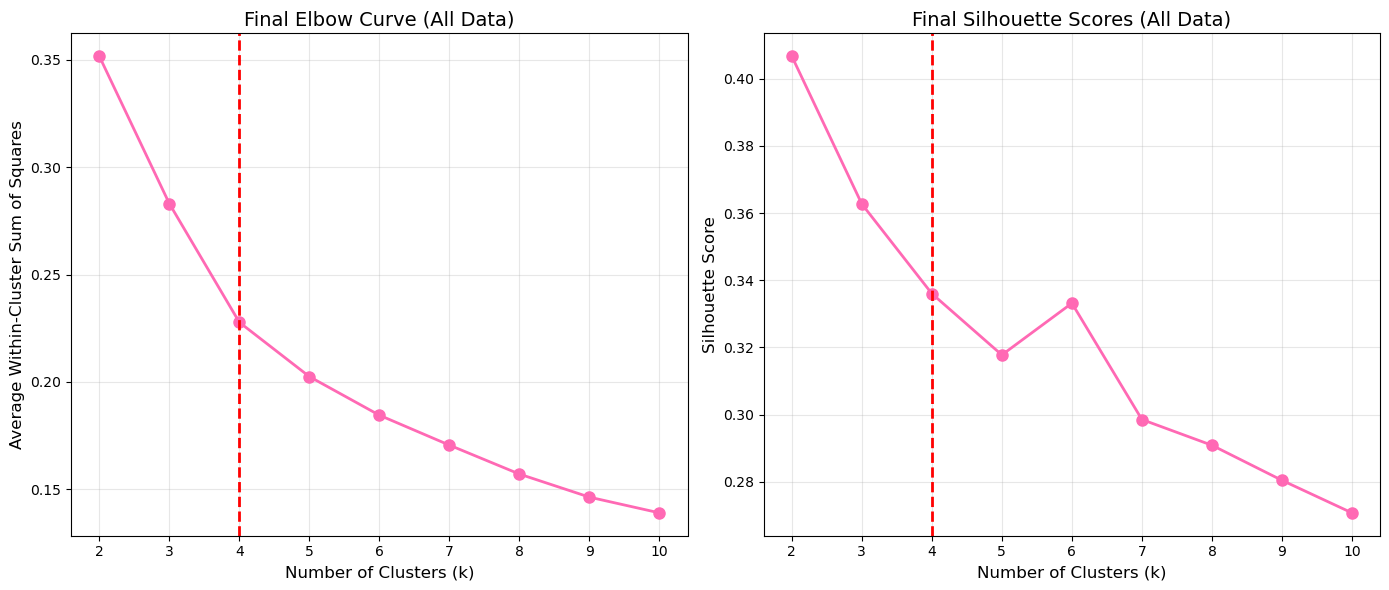

In [22]:
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans_final.fit_predict(X_scaled)

# Adding to dataframe
clustering_data['kmeans_cluster'] = kmeans_labels

# Calculating final metrics
final_silhouette = silhouette_score(X_scaled, kmeans_labels)
final_inertia = kmeans_final.inertia_ / len(X_scaled)

# Visualising final elbow curve
plt.figure(figsize=(10, 6))
final_inertias = []
final_silhouettes = []

for k in k_range:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    final_inertias.append(km.inertia_ / len(X_scaled))
    final_silhouettes.append(silhouette_score(X_scaled, km.labels_))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Final elbow curve
ax1.plot(k_range, final_inertias, color='hotpink', marker='o', linestyle='-', linewidth=2, markersize=8)
ax1.axvline(x=optimal_k, color='red', linestyle='--', linewidth=2)
ax1.set_xlabel('Number of Clusters (k)', fontsize=12)
ax1.set_ylabel('Average Within-Cluster Sum of Squares', fontsize=12)
ax1.set_title('Final Elbow Curve (All Data)', fontsize=14)
ax1.grid(True, alpha=0.3)

# Final silhouette curve
ax2.plot(k_range, final_silhouettes, color='hotpink', marker='o', linestyle='-', linewidth=2, markersize=8)
ax2.axvline(x=optimal_k, color='red', linestyle='--', linewidth=2)
ax2.set_xlabel('Number of Clusters (k)', fontsize=12)
ax2.set_ylabel('Silhouette Score', fontsize=12)
ax2.set_title('Final Silhouette Scores (All Data)', fontsize=14)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Hierarchical Clustering


Cluster sizes:
  Cluster 0: 42 countries
  Cluster 1: 16 countries
  Cluster 2: 17 countries
  Cluster 3: 22 countries


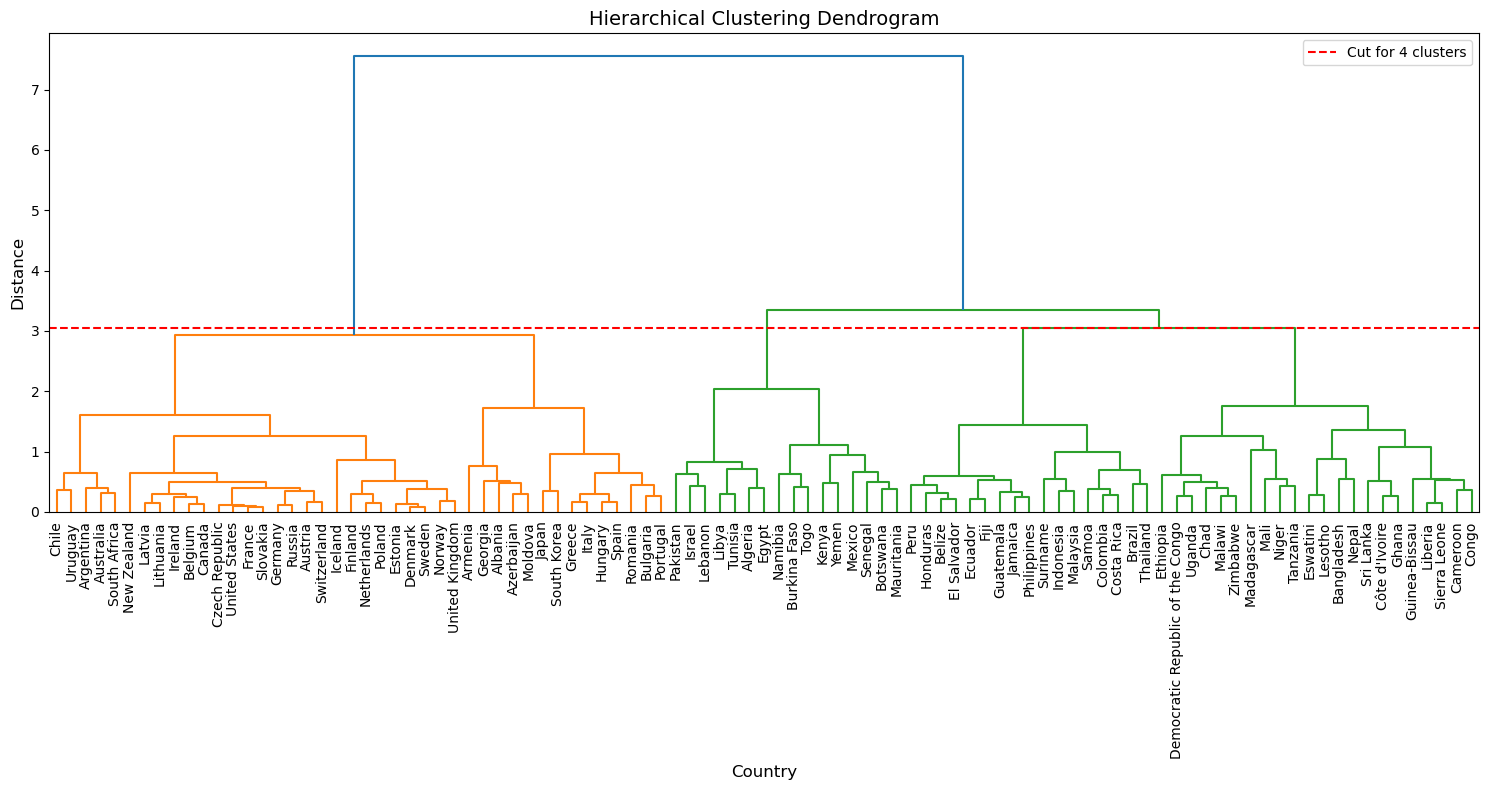

In [23]:
# Performing hierarchical clustering on all data
linkage_matrix = linkage(X_scaled, method='ward')

# Cutting at optimal k to get cluster labels
hierarchical_labels = fcluster(linkage_matrix, optimal_k, criterion='maxclust') - 1 

# Adding to dataframe
clustering_data['hierarchical_cluster'] = hierarchical_labels

print("\nCluster sizes:")
for i in range(optimal_k):
    size = (hierarchical_labels == i).sum()
    print(f"  Cluster {i}: {size} countries")

# Creating dendrogram
plt.figure(figsize=(15, 8))
dendrogram(linkage_matrix, 
           labels=clustering_data['country'].values,
           leaf_rotation=90,
           leaf_font_size=10)
plt.axhline(y=linkage_matrix[-optimal_k+1, 2], color='red', linestyle='--', 
            label=f'Cut for {optimal_k} clusters')
plt.title('Hierarchical Clustering Dendrogram', fontsize=14)
plt.xlabel('Country', fontsize=12)
plt.ylabel('Distance', fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

### Comparing K-Means & Hierarchical Clustering

In [38]:
# Calculating Adjusted Rand Index
ari_score = adjusted_rand_score(kmeans_labels, hierarchical_labels)
print(f"Adjusted Rand Index: {ari_score:.3f}")

Adjusted Rand Index: 0.656


### K-Means Performance Metrics

In [25]:
# Calculating metrics
silhouette = silhouette_score(X_scaled, kmeans_labels)
davies_bouldin = davies_bouldin_score(X_scaled, kmeans_labels)
calinski_harabasz = calinski_harabasz_score(X_scaled, kmeans_labels)
inertia = kmeans_final.inertia_

print(f"  Silhouette Score: {silhouette:.3f}")
print(f"  Davies-Bouldin Score: {davies_bouldin:.3f}")
print(f"  Calinski-Harabasz Score: {calinski_harabasz:.1f}")

# Cluster analysis
cluster_metrics = []

for i in range(optimal_k):
    cluster_mask = kmeans_labels == i
    cluster_points = X_scaled[cluster_mask]
    cluster_center = kmeans_final.cluster_centers_[i]
    
    # Within cluster metrics
    within_distances = np.linalg.norm(cluster_points - cluster_center, axis=1)
    cohesion = np.mean(within_distances)
    compactness = np.std(within_distances)
    
    # Between cluster metrics
    other_centers = np.delete(kmeans_final.cluster_centers_, i, axis=0)
    separations = np.linalg.norm(other_centers - cluster_center, axis=1)
    min_separation = np.min(separations)
    
    cluster_metrics.append({
        'cluster': i,
        'size': cluster_mask.sum(),
        'cohesion': cohesion,
        'compactness': compactness,
        'separation': min_separation,
        'quality_ratio': min_separation / cohesion})
    
    print(f"\nCluster {i} ({cluster_mask.sum()} countries):")
    print(f"  Cohesion: {cohesion:.3f}")
    print(f"  Compactness: {compactness:.3f}")
    print(f"  Min separation: {min_separation:.3f}")
    print(f"  Quality ratio: {min_separation/cohesion:.2f}")

# Save results
df_final = clustering_data[['country', 'kmeans_cluster'] + feature_columns]
df_final.to_csv('final_clustering_results.csv', index=False)

  Silhouette Score: 0.336
  Davies-Bouldin Score: 1.247
  Calinski-Harabasz Score: 58.3

Cluster 0 (27 countries):
  Cohesion: 0.527
  Compactness: 0.164
  Min separation: 0.686
  Quality ratio: 1.30

Cluster 1 (35 countries):
  Cohesion: 0.357
  Compactness: 0.146
  Min separation: 0.829
  Quality ratio: 2.32

Cluster 2 (20 countries):
  Cohesion: 0.429
  Compactness: 0.127
  Min separation: 0.686
  Quality ratio: 1.60

Cluster 3 (15 countries):
  Cohesion: 0.552
  Compactness: 0.081
  Min separation: 0.829
  Quality ratio: 1.50


### Countries in Each Cluster

In [26]:
for i in range(optimal_k):
    cluster_mask = kmeans_labels == i
    cluster_data = clustering_data[cluster_mask]
    
    print(f"\nCLUSTER {i} ({cluster_mask.sum()} countries):")
    countries_list = cluster_data['country'].tolist()
    print(", ".join(countries_list))


CLUSTER 0 (27 countries):
Botswana, Burkina Faso, Cameroon, Chad, Congo, Côte d'Ivoire, Democratic Republic of the Congo, Ethiopia, Ghana, Guinea-Bissau, Kenya, Lesotho, Liberia, Madagascar, Malawi, Mali, Mauritania, Namibia, Nepal, Niger, Senegal, Sierra Leone, Tanzania, Togo, Uganda, Yemen, Zimbabwe

CLUSTER 1 (35 countries):
Argentina, Australia, Austria, Belgium, Bulgaria, Canada, Chile, Czech Republic, Denmark, Estonia, Finland, France, Germany, Greece, Hungary, Iceland, Ireland, Italy, Japan, Latvia, Lithuania, Netherlands, New Zealand, Norway, Poland, Portugal, Russia, Slovakia, South Africa, Spain, Sweden, Switzerland, United Kingdom, United States, Uruguay

CLUSTER 2 (20 countries):
Bangladesh, Belize, Brazil, Colombia, Costa Rica, Ecuador, El Salvador, Fiji, Guatemala, Honduras, Indonesia, Jamaica, Malaysia, Mexico, Peru, Philippines, Samoa, Sri Lanka, Suriname, Thailand

CLUSTER 3 (15 countries):
Albania, Algeria, Armenia, Azerbaijan, Egypt, Eswatini, Georgia, Israel, Leban

### Feature Profiles for Each Cluster

In [29]:
# Calculating overall means for comparison
overall_means = clustering_data[feature_columns].mean()
cluster_profiles = []

for i in range(optimal_k):
    cluster_mask = kmeans_labels == i
    cluster_data = clustering_data[cluster_mask]
    
    print(f"\nCLUSTER {i} Feature Profile:")
    
    # Creating profile dictionary
    profile = {
        'cluster': i,
        'n_countries': cluster_mask.sum()}
    
    # Calculating and displaying feature values
    for feature in feature_columns:
        cluster_mean = cluster_data[feature].mean()
        overall_mean = overall_means[feature]
        diff_pct = ((cluster_mean - overall_mean) / overall_mean) * 100 if overall_mean != 0 else 0
        
        profile[feature] = cluster_mean
        profile[f'{feature}_diff_pct'] = diff_pct
        
        # Print with formatting
        print(f"  {feature:<25} {cluster_mean:>8.2f} ({diff_pct:>+6.1f}% vs global avg)")
    
    cluster_profiles.append(profile)
    
    profiles_df = pd.DataFrame(cluster_profiles)


CLUSTER 0 Feature Profile:
  ph                            5.99 (  -1.2% vs global avg)
  sand                         57.16 ( +23.6% vs global avg)
  precip_mm                  1018.78 ( -11.2% vs global avg)
  agr_employment               45.65 (+107.8% vs global avg)
  smallholder_pct              76.60 ( +45.4% vs global avg)
  food_insecurity_pct          60.33 ( +94.6% vs global avg)
  tropical_climate              1.93 ( +79.6% vs global avg)

CLUSTER 1 Feature Profile:
  ph                            5.88 (  -3.0% vs global avg)
  sand                         46.82 (  +1.2% vs global avg)
  precip_mm                   890.54 ( -22.3% vs global avg)
  agr_employment                4.08 ( -81.4% vs global avg)
  smallholder_pct              16.20 ( -69.2% vs global avg)
  food_insecurity_pct           9.56 ( -69.1% vs global avg)
  tropical_climate              0.14 ( -86.7% vs global avg)

CLUSTER 2 Feature Profile:
  ph                            5.62 (  -7.3% vs global avg)
 

### Most and Least Representative Countries for Each Cluster

In [34]:
# Getting scaled feature values for distance calculation
X_scaled = scaler.transform(clustering_data[feature_columns])

# Getting cluster centers
cluster_centers = kmeans.cluster_centers_

# Calculating distances from each point to its assigned cluster center
distances = []
for i, label in enumerate(kmeans_labels):
    dist = np.linalg.norm(X_scaled[i] - cluster_centers[label])
    distances.append(dist)

clustering_data['distance_to_center'] = distances

for cluster_id in range(optimal_k):
    cluster_mask = kmeans_labels == cluster_id
    cluster_countries = clustering_data[cluster_mask].copy()
    
    cluster_countries_sorted = cluster_countries.sort_values('distance_to_center')
    
    print(f"\nCLUSTER {cluster_id}:")
    
    print("Most Representative (closest to center):")
    top_3 = cluster_countries_sorted.head(3)
    for idx, (_, row) in enumerate(top_3.iterrows(), 1):
        print(f"  {idx}. {row['country']} (distance: {row['distance_to_center']:.3f})")
    
    print("\nLeast Representative (furthest from center):")
    bottom_3 = cluster_countries_sorted.tail(3)
    for idx, (_, row) in enumerate(bottom_3.iterrows(), 1):
        print(f"  {idx}. {row['country']} (distance: {row['distance_to_center']:.3f})")


CLUSTER 0:
Most Representative (closest to center):
  1. Ghana (distance: 0.293)
  2. Zimbabwe (distance: 0.308)
  3. Côte d'Ivoire (distance: 0.322)

Least Representative (furthest from center):
  1. Yemen (distance: 0.742)
  2. Madagascar (distance: 0.920)
  3. Namibia (distance: 0.932)

CLUSTER 1:
Most Representative (closest to center):
  1. Latvia (distance: 0.130)
  2. Canada (distance: 0.163)
  3. Lithuania (distance: 0.164)

Least Representative (furthest from center):
  1. Argentina (distance: 0.642)
  2. Japan (distance: 0.670)
  3. Iceland (distance: 0.678)

CLUSTER 2:
Most Representative (closest to center):
  1. Ecuador (distance: 0.179)
  2. Fiji (distance: 0.226)
  3. El Salvador (distance: 0.265)

Least Representative (furthest from center):
  1. Brazil (distance: 0.575)
  2. Bangladesh (distance: 0.647)
  3. Mexico (distance: 0.666)

CLUSTER 3:
Most Representative (closest to center):
  1. Azerbaijan (distance: 0.425)
  2. Romania (distance: 0.436)
  3. Israel (distan

### Radar Plots 

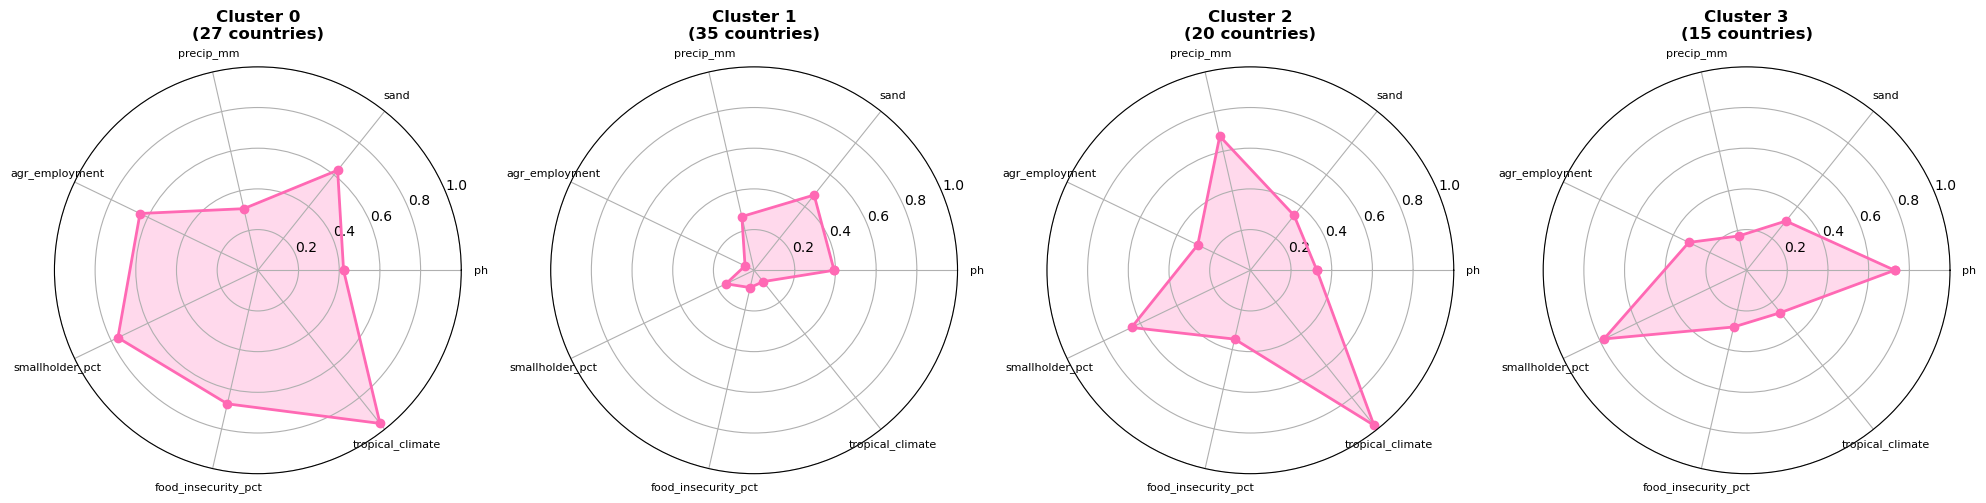

In [30]:
# Creating radar chart for visual comparison
fig, axes = plt.subplots(1, optimal_k, figsize=(5*optimal_k, 5), subplot_kw=dict(projection='polar'))
if optimal_k == 1:
    axes = [axes]

# Normalising features for radar chart
feature_ranges = {}
for feature in feature_columns:
    min_val = clustering_data[feature].min()
    max_val = clustering_data[feature].max()
    feature_ranges[feature] = (min_val, max_val)

for idx, ax in enumerate(axes):
    cluster_data = profiles_df[profiles_df['cluster'] == idx]
    
    # Preparing data for radar chart
    values = []
    for feature in feature_columns:
        val = cluster_data[feature].values[0]
        min_val, max_val = feature_ranges[feature]
        normalized = (val - min_val) / (max_val - min_val) if max_val != min_val else 0.5
        values.append(normalized)
    
    # Completing the circle
    values += values[:1]
    
    # Calculating angles
    angles = [n / float(len(feature_columns)) * 2 * pi for n in range(len(feature_columns))]
    angles += angles[:1]
    
    # Plotting
    ax.plot(angles, values, 'o-', linewidth=2, color='hotpink')
    ax.fill(angles, values, color='hotpink', alpha=0.25)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(feature_columns, size=8)
    ax.set_ylim(0, 1)
    ax.set_title(f'Cluster {idx}\n({cluster_data["n_countries"].values[0]} countries)', 
                 size=12, weight='bold', pad=20)
    ax.grid(True)

plt.tight_layout()
plt.savefig("cluster_profiles.pdf", format="pdf")
plt.show()

### Feature Sensitivity Analysis

               feature  ari_score  impact_score
2      smallholder_pct   0.711884      0.288116
5     tropical_climate   0.776852      0.223148
4       agr_employment   0.835713      0.164287
1            precip_mm   0.848712      0.151288
6                 sand   0.884288      0.115712
3  food_insecurity_pct   0.884631      0.115369
0                   ph   0.902822      0.097178


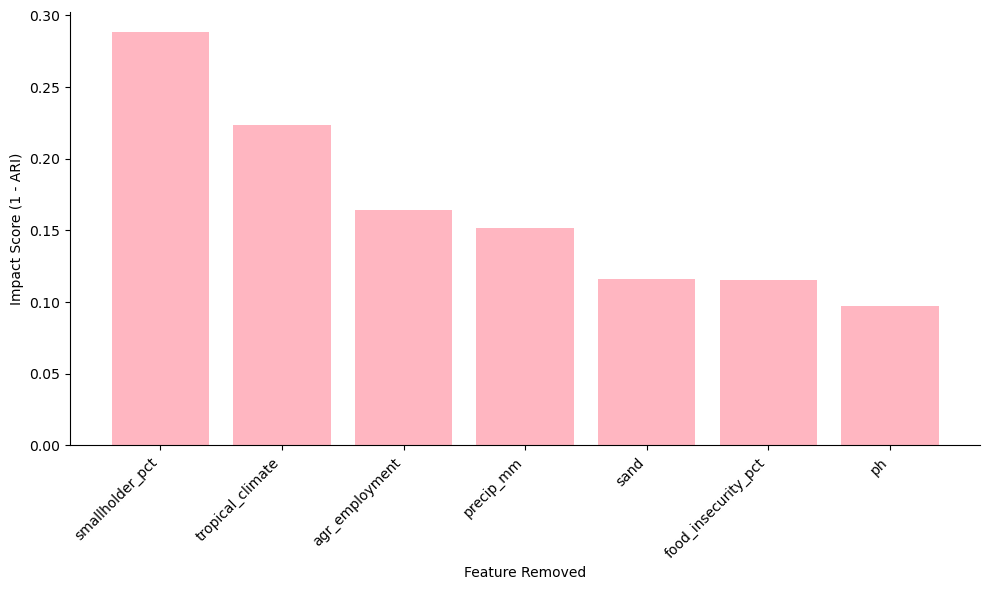

In [39]:
feature_columns = ['ph', 'precip_mm', 'smallholder_pct', 'food_insecurity_pct','agr_employment', 'tropical_climate', 'sand']

# Removing any rows with missing values
df_clean = clustering_data.dropna(subset=feature_columns)

# Baseline clustering
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(df_clean[feature_columns])
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
baseline_labels = kmeans.fit_predict(X_scaled)

# Removing one feature at a time

sensitivity_results = []

for feature_to_remove in feature_columns:
    
    features_subset = [f for f in feature_columns if f != feature_to_remove]
    
    X_subset = df_clean[features_subset].values
    scaler_subset = MinMaxScaler()
    X_subset_scaled = scaler_subset.fit_transform(X_subset)
    
    kmeans_subset = KMeans(n_clusters=4, random_state=42, n_init=10)
    subset_labels = kmeans_subset.fit_predict(X_subset_scaled)
    
    ari_score = adjusted_rand_score(baseline_labels, subset_labels)
    impact_score = 1 - ari_score
    
    sensitivity_results.append({
        'feature': feature_to_remove,
        'ari_score': ari_score,
        'impact_score': impact_score})
    
# Creating summary dataframe
sensitivity_df = pd.DataFrame(sensitivity_results)
sensitivity_df = sensitivity_df.sort_values('impact_score', ascending=False)

print(sensitivity_df)

# Create visualisation
plt.figure(figsize=(10, 6))

plt.bar(sensitivity_df['feature'],sensitivity_df['impact_score'],color='lightpink')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)

plt.grid(False)

plt.xlabel('Feature Removed', fontsize=10)
plt.ylabel('Impact Score (1 - ARI)', fontsize=10)
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.savefig("feature_importance.pdf", format="pdf")
plt.show()